#### CelebA CNN Classification
In this notebook, we will train a convolutional neural network to classify images of the CelebA dataset. 
* Statirng with a plain CNN in pytorch and 
* then using a transfer learning approach on a CNN architecture from a pretrained model and 
* another transfer learning approach on a vision transformer architecture from Hugingface's pretrained models.

##### 1. Load CelebA Dataset

In [1]:
from torchvision.datasets import CelebA
data_dir = './data/celeba'
train_dataset = CelebA(data_dir, split='train', target_type='attr', download=True)
test_dataset = CelebA(data_dir, split='test', target_type='attr', download=True)
valid_dataset = CelebA(data_dir, split='valid', target_type='attr', download=True)	    

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


#### Define image utilities

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import numpy as np

import matplotlib.pyplot as plt
def preview_image_data(dataset, transforms = None, permute = False, base_idx = None):
    fig = plt.figure(figsize=(10, 10))
    base_idx = np.random.randint(0, len(dataset)-9) if base_idx is None else base_idx
    for i in range(9):
        ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
        image = dataset[i+base_idx][0] if transforms is None else transforms(dataset[i][0])
        if permute:
            image = image.permute(1, 2, 0)
        ax.imshow(image)   
    fig.tight_layout()

def compare_image_data_tranforms(dataset, transforms, permute = False):
    fig = plt.figure(figsize=(10, 10))
    base_idx = np.random.randint(0, len(dataset)-3)
    for i in range(1, 4):
        ax0 = fig.add_subplot(2, 3, i, xticks=[], yticks=[])
        image = dataset[base_idx+i][0]
        ax0.imshow(image)

        ax1 = fig.add_subplot(2, 3, 3+i, xticks=[], yticks=[])
        image_transform = transforms(image)
        if permute:
            image_transform = image_transform.permute(1, 2, 0)
        ax1.imshow(image_transform)   
    fig.tight_layout()    
      

#### Preview images

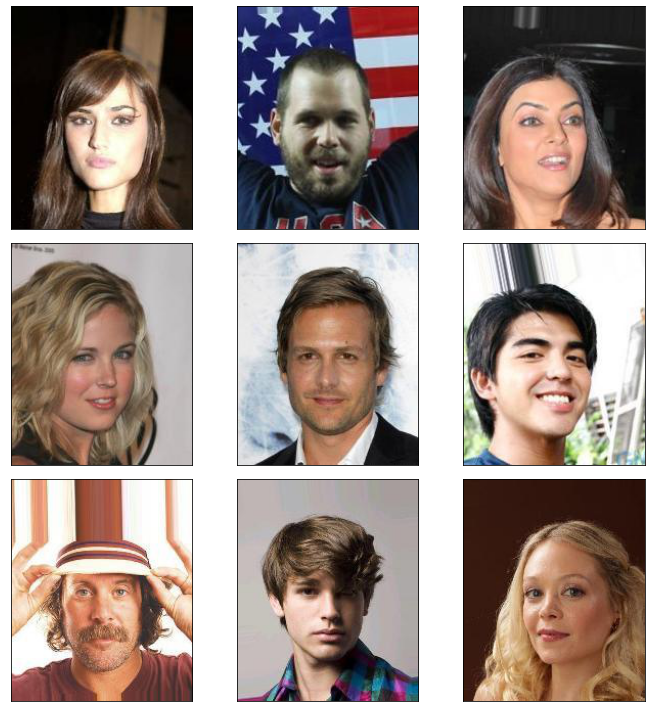

In [212]:

preview_image_data(train_dataset)

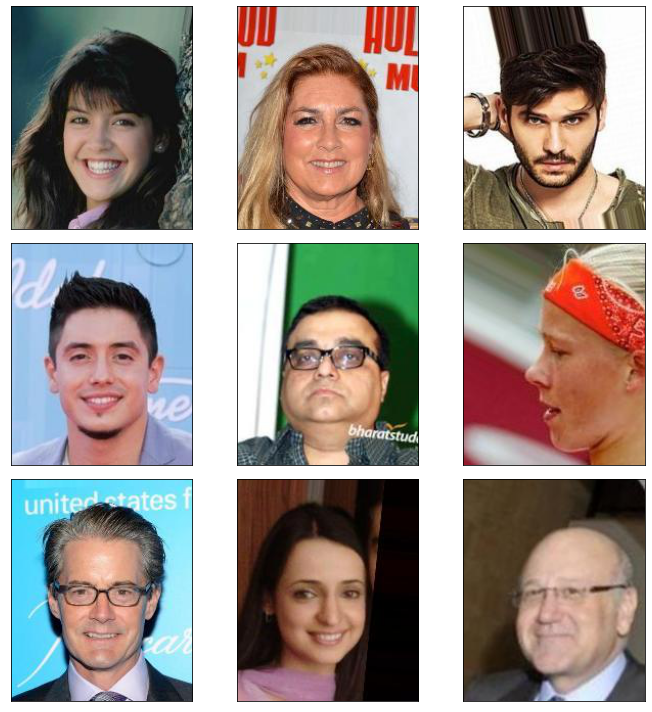

In [213]:
preview_image_data(test_dataset)

#### Create transforms for image augmentation and pre processing

In [3]:
from torchvision.transforms import Compose, RandomPerspective, RandomCrop, RandomHorizontalFlip, RandomRotation, ToTensor, CenterCrop, Resize
from torchvision.transforms import InterpolationMode
train_transforms = Compose([ 
    RandomHorizontalFlip(), 
    CenterCrop([178, 178]), 
    RandomRotation(degrees=15, interpolation=InterpolationMode.BILINEAR),  
    RandomPerspective(0.25, 0.35),
    Resize((128,128)),
    ToTensor()
])
valid_transforms = Compose([
    CenterCrop([178, 178]), 
    Resize((128,128)), 
    ToTensor()
])

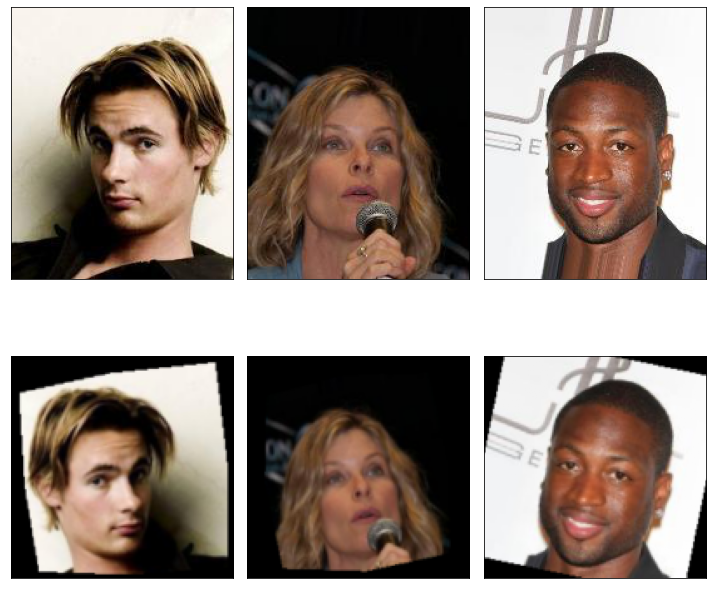

In [4]:
compare_image_data_tranforms(train_dataset, train_transforms, permute=True)

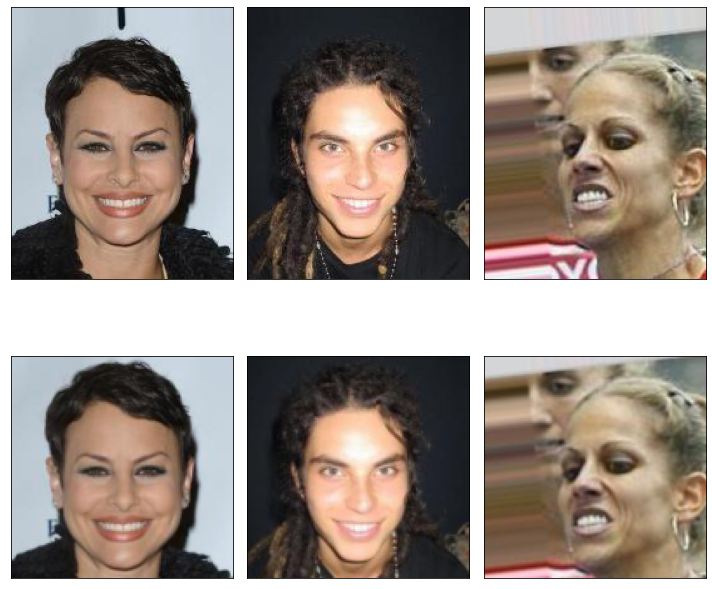

In [5]:
compare_image_data_tranforms(test_dataset, valid_transforms, permute=True)

#### Load datasets with transforms and create DataLoaders


In [6]:
from torchvision.datasets import CelebA
data_dir = './data/celeba'
smile_transform = lambda attr: attr[18]
train_dataset = CelebA(data_dir, split='train', target_type='attr', download=True, transform=train_transforms, target_transform=smile_transform)
test_dataset = CelebA(data_dir, split='test', target_type='attr', download=True, transform=valid_transforms, target_transform=smile_transform)
valid_dataset = CelebA(data_dir, split='valid', target_type='attr', download=True, transform=valid_transforms, target_transform=smile_transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [7]:
len(train_dataset)

162770

In [8]:
from torch.utils.data import Subset
torch.backends.cuda.matmul.allow_tf32 = True
# train_subset = Subset(train_dataset, range(16000*3))
# valid_subset = Subset(valid_dataset, range(2000))
train_data_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=20)
test_data_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=20)
valid_data_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=20)

#### Create a base CNN architecture

In [9]:
from torch.nn import functional as F
from torch import nn
from torch.nn import BCEWithLogitsLoss

def conv2d_sep(in_channels, out_channels, kernel_size):
    depth_conv = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=kernel_size, groups=in_channels, padding='same')
    point_conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, padding='same')
    return nn.Sequential(depth_conv, point_conv)

def conv2d(in_channels, out_channels, kernel_size):
    return nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding='same')    

def add_conv_module_fn(separable_conv):
    conv_fn = conv2d if not separable_conv else conv2d_sep
    def add_conv_module(seq_model, in_channels, out_channels, num, kernel_size=5, pool=True):
        seq_model.add_module(f'conv{num}', conv_fn(in_channels, out_channels, kernel_size))
        seq_model.add_module(f'batchnorm{num}', nn.BatchNorm2d(out_channels))
        seq_model.add_module(f'relu{num}', nn.ReLU())
        if pool:
            seq_model.add_module(f'pool{num}', nn.MaxPool2d(kernel_size=2))
    return add_conv_module        
    

def create_conv_model(separable_conv=False):
    add_conv_module = add_conv_module_fn(separable_conv)
    cnn_model = nn.Sequential()
    add_conv_module(cnn_model, 3, 16, num=0)
    add_conv_module(cnn_model, 16, 32, num=1, pool=False)
    cnn_model.add_module('dropout1', nn.Dropout(0.35))
    add_conv_module(cnn_model, 32, 64, num=2)
    add_conv_module(cnn_model, 64, 128, num=3)
    cnn_model.add_module('dropout3', nn.Dropout(0.35))
    add_conv_module(cnn_model, 128, 256, num=4)
    add_conv_module(cnn_model, 256, 512, num=5, pool=False)
    cnn_model.add_module('global_avg_pool', nn.AvgPool2d(kernel_size=8))
    cnn_model.add_module('flatten', nn.Flatten())
    cnn_model.add_module('dropout4', nn.Dropout(0.35))
    cnn_model.add_module('fc2', nn.Linear(512, 1))
    return cnn_model

##Verify the model with expected input shape
create_conv_model()(torch.randn(1, 3, 128, 128)).shape

torch.Size([1, 1])

#### Create the training loop function

In [10]:
from tqdm.auto import tqdm
from torch.functional import F
from torch.optim.lr_scheduler import MultiStepLR


def train_model(model, loss_fn, train_dl, valid_dl, device, epochs=5):
    scaler = torch.cuda.amp.GradScaler()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)
    scheduler = MultiStepLR(optimizer, milestones=[7, 14, 21], gamma=0.1)
    
    train_len = len(train_dl.dataset)
    valid_len = len(valid_dl.dataset)
    progress_bar = tqdm(range(epochs*len(train_dl)))
    model.to(device)
    for epoch in range(epochs):
        model.train()
        train_acc = 0
        train_loss = 0
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            with torch.cuda.amp.autocast():  
                y_pred = model(x_batch)[:,0]
                loss = loss_fn(y_pred, y_batch.float())
            # loss.backward()
            scaler.scale(loss).backward()
            train_loss += loss.item()
            # optimizer.step()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            progress_bar.update(1)
            train_acc += (torch.sigmoid(y_pred).round() == y_batch).float().sum().item()
        
        train_acc /= train_len
        train_loss /= train_len

        model.eval()
        with torch.no_grad():
            valid_loss = 0
            accuracy = 0
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device) 
                y_pred = model(x_batch)[:,0]
                valid_loss += loss_fn(y_pred, y_batch.float()).item()
                accuracy += (torch.sigmoid(y_pred).round() == y_batch).float().sum().item()
            valid_loss /= valid_len
            accuracy /= valid_len
            print(f'Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} - Valid Loss: {valid_loss:.4f} - Valid Acc: {accuracy:.4f}')
        scheduler.step()


In [11]:
bce_loss = BCEWithLogitsLoss()
device = torch.device('cuda')
model = create_conv_model(separable_conv=True)
train_model(model, bce_loss, train_data_loader, valid_data_loader, device, epochs=28)

  0%|          | 0/35616 [00:00<?, ?it/s]

Epoch 1/28 - Train Loss: 0.0027 - Train Acc: 0.8413 - Valid Loss: 0.0020 - Valid Acc: 0.8897
Epoch 2/28 - Train Loss: 0.0020 - Train Acc: 0.8859 - Valid Loss: 0.0018 - Valid Acc: 0.8969
Epoch 3/28 - Train Loss: 0.0019 - Train Acc: 0.8918 - Valid Loss: 0.0018 - Valid Acc: 0.9008
Epoch 4/28 - Train Loss: 0.0019 - Train Acc: 0.8942 - Valid Loss: 0.0019 - Valid Acc: 0.8921
Epoch 5/28 - Train Loss: 0.0018 - Train Acc: 0.8962 - Valid Loss: 0.0018 - Valid Acc: 0.8971
Epoch 6/28 - Train Loss: 0.0018 - Train Acc: 0.8990 - Valid Loss: 0.0018 - Valid Acc: 0.9025


KeyboardInterrupt: 

In [ ]:
bce_loss = BCEWithLogitsLoss()
device = torch.device('cuda')
model = create_conv_model(separable_conv=True)
train_model(model, bce_loss, train_data_loader, valid_data_loader, device, epochs=2)

In [13]:
torch.save(model.state_dict(), './smile_detector.pt')

In [14]:
torch.save(model, './smile_detector_complete.pt')